In [97]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense, Dropout
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os
import pickle
from utils.functions import sample, get_error_term
from model.vae_model import vae_model

In [98]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

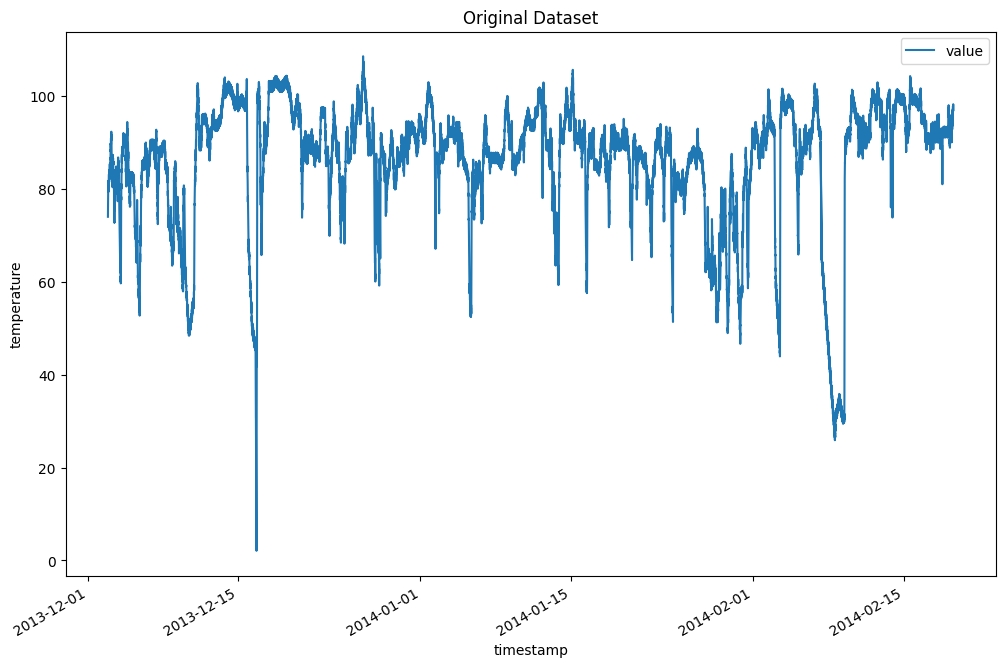

In [99]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset")

In [100]:
data['label'] = 1
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances= lists[0]


In [101]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 0

In [102]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2013-12-02 21:15:00,73.967322,1
1,2013-12-02 21:20:00,74.935882,1
2,2013-12-02 21:25:00,76.124162,1
3,2013-12-02 21:30:00,78.140707,1
4,2013-12-02 21:35:00,79.329836,1
...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1
22691,2014-02-19 15:10:00,97.804168,1
22692,2014-02-19 15:15:00,97.135468,1
22693,2014-02-19 15:20:00,98.056852,1


In [103]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week,holiday
0,2013-12-02 21:15:00,73.967322,1,2,12,21.250000,0,0
1,2013-12-02 21:20:00,74.935882,1,2,12,21.333333,0,0
2,2013-12-02 21:25:00,76.124162,1,2,12,21.416667,0,0
3,2013-12-02 21:30:00,78.140707,1,2,12,21.500000,0,0
4,2013-12-02 21:35:00,79.329836,1,2,12,21.583333,0,0


In [104]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [105]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [106]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [107]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,label,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,12,21.250000,0,0,-23,13860189
1,74.935882,1,2,12,21.333333,0,0,-23,13860192
2,76.124162,1,2,12,21.416667,0,0,-23,13860195
3,78.140707,1,2,12,21.500000,0,0,-23,13860198
4,79.329836,1,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,19,2,15.083333,2,0,49,13928223
22691,97.804168,1,19,2,15.166667,2,0,49,13928226
22692,97.135468,1,19,2,15.250000,2,0,49,13928229
22693,98.056852,1,19,2,15.333333,2,0,49,13928232


In [108]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [109]:
from sklearn.preprocessing import LabelEncoder

# label_encoders = [LabelEncoder() for _ in cat_vars] 
# for col, enc in zip(cat_vars, label_encoders):
#     data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,73.967322,1,21.250000,-23,13860189,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,74.935882,1,21.333333,-23,13860192,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,76.124162,1,21.416667,-23,13860195,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,78.140707,1,21.500000,-23,13860198,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,79.329836,1,21.583333,-23,13860201,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,15.083333,49,13928223,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,97.804168,1,15.166667,49,13928226,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,97.135468,1,15.250000,49,13928229,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,98.056852,1,15.333333,49,13928232,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [110]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'gap_holiday', 't', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'month_1', 'month_2', 'month_12', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'holiday_0', 'holiday_1'],
      dtype='object')


In [111]:
# Splitting to train and test
train_start = int(len(data) * 0.2)
train_end = int(len(data) * 0.7)
test_start= int(len(data) * 0.8) 
tr_data = data.iloc[train_start:train_end]
tst_data = data.iloc[test_start :]

Visualizing the split up

Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

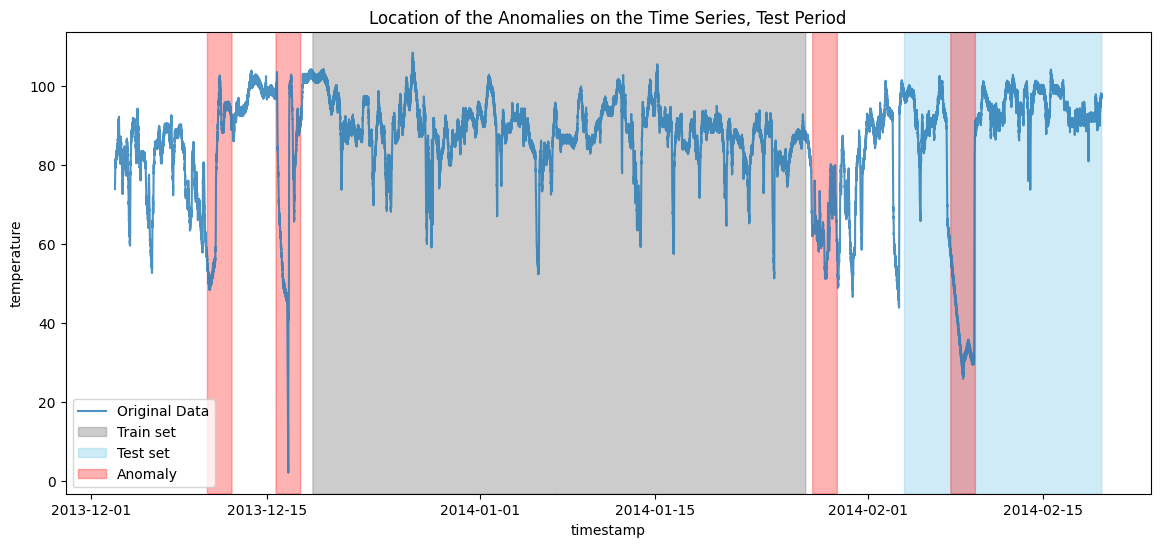

In [112]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.8)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=(data_w_ts['timestamp'] > data_w_ts['timestamp'].iloc[train_start]) & (data_w_ts['timestamp'] < data_w_ts['timestamp'].iloc[train_end]), color='gray', alpha=0.4, transform=ax.get_xaxis_transform(),label='Train set')
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=(data_w_ts['timestamp'] > data_w_ts['timestamp'].iloc[test_start]) & (data_w_ts['timestamp'] < data_w_ts['timestamp'].iloc[len(data)-1]), color='skyblue', alpha=0.4, transform=ax.get_xaxis_transform(),label='Test set')
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=np.logical_not(data_w_ts['label']), color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Anomaly')

plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")

In [113]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [114]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [115]:
tr_data_scaled

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
4539,1.892852,1,0.501637,-1.589436,-1.732794,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4540,1.908274,1,0.513639,-1.589436,-1.732488,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4541,1.846107,1,0.525641,-1.589436,-1.732182,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4542,1.947799,1,0.537643,-1.589436,-1.731876,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4543,1.909759,1,0.549644,-1.589436,-1.731571,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.008683,1,1.677804,1.879626,1.731612,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,-0.000939,1,1.689805,1.879626,1.731917,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.026452,1,1.701807,1.879626,1.732223,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,-0.083406,1,1.713809,1.879626,1.732529,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [116]:
tst_data_scaled

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
18156,1.333016,1,1.329754,2.746891,2.427245,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
18157,1.093438,1,1.341756,2.746891,2.427550,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
18158,1.346040,1,1.353758,2.746891,2.427856,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
18159,1.169718,1,1.365759,2.746891,2.428162,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
18160,1.172035,1,1.377761,2.746891,2.428468,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,1.261405,1,0.441629,4.481422,3.813618,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,1.212244,1,0.453631,4.481422,3.813924,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,1.126016,1,0.465632,4.481422,3.814230,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,1.244827,1,0.477634,4.481422,3.814536,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [117]:
train = tr_data_scaled[tr_data_scaled.label != 0]
train= train.drop(columns=['label'])
train

,value,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,day_6,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
4539,1.892852,0.501637,-1.589436,-1.732794,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4540,1.908274,0.513639,-1.589436,-1.732488,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4541,1.846107,0.525641,-1.589436,-1.732182,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4542,1.947799,0.537643,-1.589436,-1.731876,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4543,1.909759,0.549644,-1.589436,-1.731571,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.008683,1.677804,1.879626,1.731612,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,-0.000939,1.689805,1.879626,1.731917,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.026452,1.701807,1.879626,1.732223,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,-0.083406,1.713809,1.879626,1.732529,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [118]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [119]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [120]:
vae_model= vae_model(train)
vae_model.summary()

results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,824 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 23)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47)        │      1,496 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_2    │ (None, 47)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,320 (12.97 KB)

 Trainable params: 3,320 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2168.7271 - val_loss: 1895.3268
Epoch 2/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2049.3220 - val_loss: 1814.7531
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1951.3269 - val_loss: 1735.8800
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1862.6018 - val_loss: 1666.1012
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1772.2844 - val_loss: 1598.6125
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1689.3058 - val_loss: 1521.7017
Epoch 7/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1591.9254 - val_loss: 1446.9352
Epoch 8/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1497.1367 - val_loss: 1372.0941
Epoch 9/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1402.7502 - val_loss: 1293.8319
Epoch 10/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1300.3907 - val_loss: 1227.3324
Epoch 11/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1205.5001 - val_lo

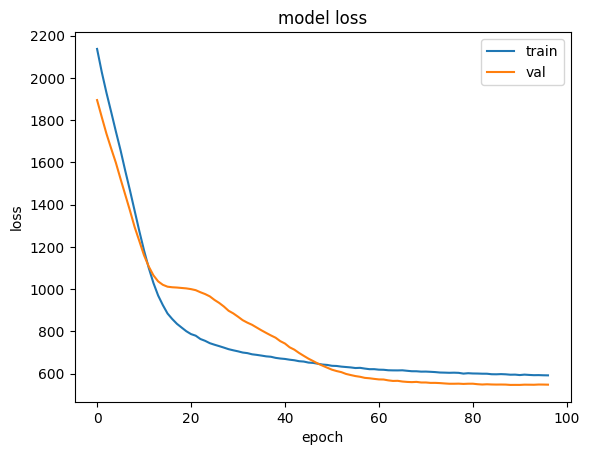

In [121]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [122]:
train_pred = vae_model.predict(train)[0]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


In [123]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
# print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

# error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.28848797082901
median error 0.27566832304000854
99Q: 0.5631215488910674


(array([ 21., 152., 584., 811., 892., 740., 727., 790., 687., 499., 569.,
        650., 673., 583., 501., 475., 276., 381., 348., 145., 145., 178.,
         87.,  64.,  54.,  37.,  30.,  37.,  26.,  20.,   7.,  12.,  10.,
         11.,  14.,  13.,  16.,   7.,   6.,  12.,   5.,   5.,   5.,   5.,
          8.,   7.,  11.,   8.,   1.,   2.]),
 array([0.16653974, 0.17800561, 0.18947147, 0.20093733, 0.21240319,
        0.22386906, 0.23533493, 0.2468008 , 0.25826666, 0.26973251,
        0.28119838, 0.29266426, 0.30413011, 0.31559598, 0.32706183,
        0.33852771, 0.34999356, 0.36145943, 0.37292528, 0.38439116,
        0.39585704, 0.40732288, 0.41878876, 0.43025461, 0.44172049,
        0.45318633, 0.46465221, 0.47611806, 0.48758394, 0.49904978,
        0.51051569, 0.52198154, 0.53344738, 0.54491323, 0.55637914,
        0.56784499, 0.57931083, 0.59077668, 0.60224259, 0.61370844,
        0.62517428, 0.63664019, 0.64810604, 0.65957189, 0.67103773,
        0.68250364, 0.69396949, 0.70543534, 0.

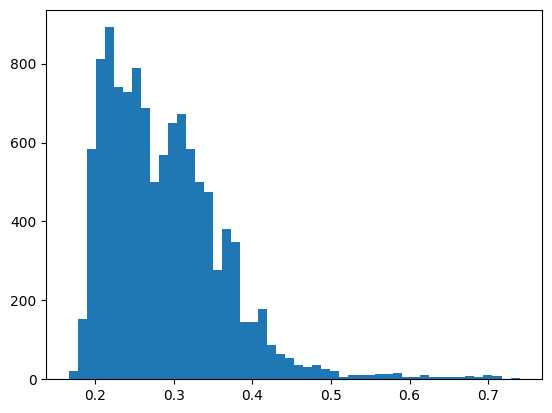

In [124]:
plt.hist(mae_vector, bins=50)

In [125]:
error_thresh = np.max(mae_vector) 
print(f'setting threshold on {error_thresh} ')

setting threshold on 0.7398329377174377 


In [126]:
#Actual ratio of anomalies 
ratio=1-np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.12491738268341046


In [127]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
Avg error 0.6767154335975647
median error 0.648044764995575


0.13725490196078433

(array([194., 275., 160., 155., 186., 112., 263., 183., 202., 286., 273.,
        351., 205., 506., 275., 241.,  94.,  33.,  13.,   8.,  11.,   8.,
          8.,  12.,  12.,   8.,  11.,   6.,  10.,   3.,   4.,   7.,  14.,
         10.,   9.,  16.,   8.,   8.,  15.,   7.,  17.,  31.,  57.,  68.,
         73.,  42.,  19.,  11.,  15.,   4.]),
 array([0.46666962, 0.48324388, 0.49981818, 0.51639247, 0.53296673,
        0.549541  , 0.56611526, 0.58268958, 0.59926385, 0.61583811,
        0.63241237, 0.64898664, 0.66556096, 0.68213522, 0.69870949,
        0.71528375, 0.73185807, 0.74843234, 0.7650066 , 0.78158087,
        0.79815513, 0.81472945, 0.83130372, 0.84787798, 0.86445224,
        0.88102651, 0.89760083, 0.91417509, 0.93074936, 0.94732362,
        0.96389794, 0.98047221, 0.99704647, 1.01362073, 1.030195  ,
        1.04676926, 1.06334352, 1.07991791, 1.09649217, 1.11306643,
        1.1296407 , 1.14621496, 1.16278923, 1.17936349, 1.19593775,
        1.21251202, 1.2290864 , 1.24566066, 1.

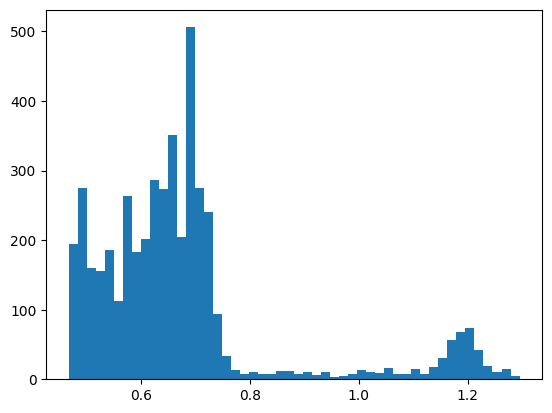

In [128]:
plt.hist(mae_vector_test, bins=50)

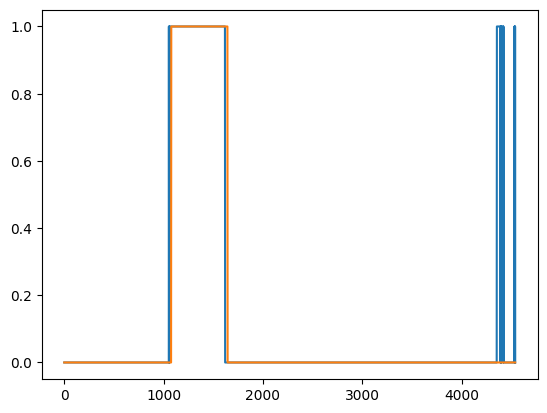

In [129]:
plt.plot(anomalies)
plt.plot(np.logical_not(labels_of_test))

In [130]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

C:\Users\99anj\AppData\Local\Temp\ipykernel_15504\3776165707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_15504\3776165707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


Text(0.5, 1.0, 'Location of the Anomalies on the Test set')

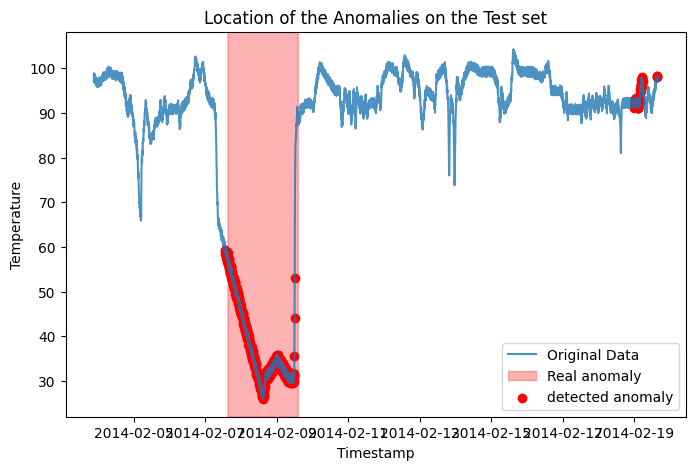

In [139]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==0, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]


# Modify the plot shuch that the train and test sets are shown
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(data_w_ts['timestamp'].iloc[test_start :], data_w_ts['value'].iloc[test_start :], label='Original Data', alpha=0.8)
ax.fill_between(data_w_ts['timestamp'].iloc[test_start :], 0, 1, where=np.logical_not(data_w_ts['label'].iloc[test_start :]), color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='red', label='detected anomaly')
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Location of the Anomalies on the Test set")

In [132]:
from utils.scoring import score_fn
anomaly_ranges = [(datetime.strptime(start, "%Y-%m-%d %H:%M:%S"), 
                       datetime.strptime(end, "%Y-%m-%d %H:%M:%S")) for start, end in instances[3:]]
res = score_fn(testing['timestamp'], anomaly_ranges)
print (res)
print (f'Score: {np.sum(res)}')

[-0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0